In [11]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from statistics import mean
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold

from sklearn.metrics import roc_auc_score

from itertools import combinations

# Unweighted Similarity based Features

In [3]:
unweighted_train = pd.read_csv("small_train_sm.csv")

,Source,Sink,NCA,Exist,Pair,CN,AA,RA,JC,PA,KI,PR
0,1709,2591,0,0,"(1709, 2591)",0,0.000000,0.000000,0.000000,80,0.000046,0.000360
1,1445,3222,0,0,"(1445, 3222)",0,0.000000,0.000000,0.000000,4,0.000002,0.000214
2,395,3684,0,0,"(395, 3684)",0,0.000000,0.000000,0.000000,14,0.000000,0.000235
3,3572,3618,0,0,"(3572, 3618)",0,0.000000,0.000000,0.000000,12,-0.000079,0.000147
4,859,1755,0,0,"(859, 1755)",0,0.000000,0.000000,0.000000,30,0.013973,0.000165
...,...,...,...,...,...,...,...,...,...,...,...,...
32067,3793,3892,2,1,"(3793, 3892)",3,0.991957,0.153636,0.068182,532,0.048659,0.000740
32068,3793,3920,2,1,"(3793, 3920)",1,0.300102,0.035714,0.034483,209,0.057119,0.000425
32069,3872,3932,1,1,"(3872, 3932)",0,0.000000,0.000000,0.000000,280,0.003370,0.000650
32070,3892,3944,2,1,"(3892, 3944)",3,0.866132,0.094985,0.083333,308,0.056622,0.000693


In [4]:
y = unweighted_train['Exist']
X = unweighted_train[['CN', 'AA', 'RA', 'JC', 'PA', 'KI', 'PR']]

In [5]:
# Code adapted from Worksheet04 to calculate the coefficients
clf = LogisticRegression(penalty='none')
clf.fit(X, y)
w_sklearn = np.r_[clf.intercept_, clf.coef_.squeeze()]
print("Weights according to scikit-learn: {}".format(w_sklearn))

Weights according to scikit-learn: [-2.49209876e+00 -1.75417092e+00  1.47063455e+01  6.52069745e+00
  4.39409672e+00 -8.57675074e-05  1.18520584e+00  3.00593702e-02]


/Users/abigail/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [6]:
# Fitting a model with all features

n_splits=5
sss = StratifiedShuffleSplit(n_splits=n_splits, random_state=0)

gnb = LogisticRegression(penalty='none')
auc = []
for train_index, test_index in sss.split(X, y):
    # split the train data and test data
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    y_pred = gnb.fit(X_train, y_train).predict_proba(X_test)
    auc.append(roc_auc_score(y_test, y_pred[:,1]))

print("The average AUC of LG including all unweighted features is:", mean(auc))

/Users/abigail/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/abigail/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

The average AUC of NB including all features is: 0.9876113177156859


/Users/abigail/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Single Unweighted Similarity Based Features

In [12]:
# Fitting models with single attribute
uwF = ['CN', 'AA', 'RA', 'JC', 'PA', 'KI', 'PR']
X = unweighted_train[uwF]
y = unweighted_train['Exist']

kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
auc_single = []

for fN in uwF:
    gnb = LogisticRegression(penalty='none')
    auc = []
    for train_index, test_index in kf.split(X, y):
        # split the train data and test data
        X_train, X_test = X[[fN]].iloc[train_index,:], X[[fN]].iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]

        y_pred = gnb.fit(X_train, y_train).predict_proba(X_test)
        auc.append(roc_auc_score(y_test, y_pred[:,1]))
    auc_single.append(mean(auc))

auc_single = pd.DataFrame({'Features': uwF, 'AUC': auc_single}).set_index('Features')
auc_single

,AUC
Features,
CN,0.961625
AA,0.963377
RA,0.963800
JC,0.962311
PA,0.854541
KI,0.321103
PR,0.830595


# Node2Vec 

In [63]:
test = pd.read_csv("test_uw_20.csv")
test

,Source,Sink,Pair,Exist,n2v_1,n2v_2,n2v_3,n2v_4,n2v_5,n2v_6,...,n2v_11,n2v_12,n2v_13,n2v_14,n2v_15,n2v_16,n2v_17,n2v_18,n2v_19,n2v_20
0,1583,1090,"(1583, 1090)",1,0.405860,-0.485666,0.529616,-0.081629,0.129721,-0.999598,...,0.027625,-1.244332,-0.360216,-1.038564,0.230954,0.035577,0.575879,-0.648345,-0.238669,-0.571309
1,141,3675,"(141, 3675)",1,-0.254965,-0.500808,-0.003553,0.940730,-0.675909,0.105107,...,0.374818,-0.648701,0.039145,-0.251630,0.888812,0.735141,-0.060172,-1.220340,-0.658771,-0.891588
2,1090,3599,"(1090, 3599)",1,0.154408,-0.871820,0.775540,-0.233394,-0.034123,-1.078372,...,-0.091710,-1.364243,-0.522186,-1.177989,0.495516,0.217865,0.224449,-0.610465,-0.461822,-0.460719
3,2754,2434,"(2754, 2434)",1,-0.145123,-0.482341,0.039316,1.038831,-1.109347,-0.675329,...,0.506095,-0.296087,1.543097,0.221983,0.352063,0.269220,-0.329852,-0.406578,-0.801259,-0.928940
4,3333,1354,"(3333, 1354)",1,0.201629,-0.137475,0.461126,-0.121809,-1.265341,-0.750411,...,1.554670,-0.161988,-0.433174,0.370734,0.143914,-0.458284,0.544586,-1.057547,-0.328479,-0.321587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3201,3043,1997,"(3043, 1997)",0,-0.141355,0.537051,-0.905092,0.320851,-0.075597,-1.942401,...,0.499547,0.302875,-1.111789,-1.210547,-0.233610,0.667532,0.199015,-1.384570,-0.350485,-1.502618
3202,1448,3709,"(1448, 3709)",0,-1.130277,-0.975209,1.099432,-0.071342,-1.052601,0.495470,...,0.684125,-0.564651,0.530093,-0.181188,0.047075,1.302829,0.102146,-1.995122,-0.364623,-0.511124
3203,3889,877,"(3889, 877)",0,0.564638,-0.919990,0.588639,0.435731,-0.302456,-1.564138,...,0.621292,-0.362167,-0.061629,0.866844,1.568223,2.235245,-0.432375,-2.242313,-1.616804,-1.268739
3204,2994,3101,"(2994, 3101)",0,-0.078170,-0.212546,0.956161,0.332179,-0.650847,-0.326858,...,0.767074,-0.006071,-1.018078,-0.471682,0.615400,0.362470,0.138886,-1.011707,-0.723952,-0.585730


In [68]:
ds = [15, 20, 25, 30, 35, 40, 45, 50, 55]
auc_n2v = []
for d in ds:
    train = pd.read_csv("small_train_n2v_{}.csv".format(d))
    n2vF = ["n2v_"+str(i+1) for i in range(d)] # node2vec feature list
    X = train[n2vF]
    y = train['Exist']

    
    clf = LogisticRegression(penalty='none')
    clf.fit(X, y)
    w_sklearn = np.r_[clf.intercept_, clf.coef_.squeeze()]
    
    X.insert(0,'Intercept',1)
    predict = sigmoid(X @ w_sklearn)

    auc_n2v.append(roc_auc_score(y, predict))
    
    
auc_n2v = pd.DataFrame(auc_n2v, columns=["AUC"])
auc_n2v.index = ds
auc_n2v

,AUC
15,0.791933
20,0.797716
25,0.800738
30,0.801652
35,0.803676
40,0.802310
45,0.804539
50,0.808026
55,0.807363


# Weighted Similarity based Features

### Finding the optimal alpha

In [16]:
alphas = [round(a*0.1,1) for a in range(21, 25)]
weak_ties = ["alphas/weak_ties_{}.csv".format(alpha) for alpha in alphas]

unweighted_features = unweighted_train[['Pair', 'CN', 'AA', 'RA', 'Exist']]

auc_alpha=[]
for weak_tie in weak_ties:
    weighted_train = pd.read_csv(weak_tie, index_col=0)
    both = unweighted_features.join(weighted_train, on="Pair")
    X = both[['WCN', 'WAA', 'WRA']]
    y = both["Exist"]
    
    auc=[]
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        
        y_pred = gnb.fit(X_train, y_train).predict_proba(X_test)
        auc.append(roc_auc_score(y_test, y_pred[:,1]))
    
    auc_alpha.append(mean(auc))

auc_alphaDF = pd.DataFrame(auc_alpha, columns=['AUC'])
auc_alphaDF.index = alphas
auc_alphaDF.head()

,AUC
2.1,0.963548
2.2,0.963502
2.3,0.963458
2.4,0.963414


In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(auc_alphaDF.index, auc_alphaDF.AUC, s=10, c='b', marker="o")

plt.show()

In [ ]:
print('The optimal alpha is {}'.format(auc_alphaDF.AUC.idxmax()))

# Train-test split AUC Calculation

## For unweighted features

In [17]:
train = pd.read_csv("train_uw_20.csv")
test = pd.read_csv("test_uw_20.csv")
train

,Source,Sink,Pair,Exist,CN,AA,RA,JC,PA,KI,...,n2v_11,n2v_12,n2v_13,n2v_14,n2v_15,n2v_16,n2v_17,n2v_18,n2v_19,n2v_20
0,3460,2537,"(3460, 2537)",1,1,0.234594,0.014085,0.047619,96,0.000000e+00,...,0.944849,-0.504632,0.865158,0.730363,-0.285703,0.289974,0.211050,-0.546599,-0.612326,-0.905899
1,1173,3034,"(1173, 3034)",1,37,9.603520,0.820722,0.308333,6150,4.631072e-03,...,0.449672,-0.235038,0.684576,-0.249175,0.494600,0.314744,0.618221,-0.008499,-0.659097,-0.212555
2,198,1398,"(198, 1398)",1,2,0.883168,0.209524,0.050000,152,7.974225e-03,...,-0.172029,-0.207523,0.669493,-0.893401,0.966714,1.383621,-0.830097,-1.018111,-0.117986,-0.904438
3,1724,1548,"(1724, 1548)",1,0,0.000000,0.000000,0.000000,102,0.000000e+00,...,0.314600,-0.725000,0.471229,-0.391107,0.561173,1.468357,1.240060,-0.823748,-0.982676,-1.380628
4,1842,2451,"(1842, 2451)",1,3,1.964017,0.650000,0.500000,18,8.433238e-03,...,0.510806,0.161583,-0.633481,0.600220,-2.011025,2.340898,2.140659,-1.192981,-0.753609,-3.404449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2881,1488,3561,"(1488, 3561)",0,0,0.000000,0.000000,0.000000,2,8.653551e-07,...,0.931423,-0.660120,0.434489,0.559628,1.583344,1.916148,-0.001072,-0.420785,-1.338188,-2.440139
2882,3613,82,"(3613, 82)",0,0,0.000000,0.000000,0.000000,180,0.000000e+00,...,0.671300,-0.083306,-0.530450,0.347784,0.409858,0.645548,0.108382,-0.502386,-1.156621,-0.976718
2883,531,2698,"(531, 2698)",0,0,0.000000,0.000000,0.000000,12,1.600159e-05,...,0.935064,0.386707,0.501289,0.322686,-0.307612,1.175061,0.956102,-0.550548,-0.398839,-0.989922
2884,2443,1067,"(2443, 1067)",0,0,0.000000,0.000000,0.000000,4,0.000000e+00,...,0.582213,0.523751,-0.734892,0.426967,-0.708452,1.899273,2.507246,-1.166077,-1.506296,-1.818029


In [18]:
y = train['Exist']
X = train.drop(columns=["Pair", "Source", "Sink", "Exist"])

In [19]:
# Code adapted from Worksheet04 to calculate the coefficients
clf = LogisticRegression(penalty='none')
clf.fit(X, y)
w_sklearn = np.r_[clf.intercept_, clf.coef_.squeeze()]
print("Weights according to scikit-learn: {}".format(w_sklearn))

Weights according to scikit-learn: [ 8.19775782e-02  3.59653886e+00  2.37528548e+00  7.33597357e-01
  1.18835170e+00 -5.26375944e-04  4.44170802e-02  1.16251080e-03
  6.23524647e-01 -3.86082770e-01 -2.63905552e-01  5.86626087e-02
  1.37705332e-01 -4.54563712e-01 -3.97698960e-01 -3.96166077e-01
 -5.43007924e-03  9.60775174e-02 -3.06957438e-02  1.41622606e-01
 -2.80504176e-01 -5.33935432e-02 -1.38641019e-01 -6.66757921e-01
 -6.05439367e-01  1.59879267e-01  3.78370820e-01  5.99473474e-01]


/Users/abigail/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [23]:
y_test = test['Exist']
X_test = test.drop(columns=["Pair", "Source", "Sink", "Exist"])
X_test.insert(0,'Intercept',1)
X_test

,Intercept,CN,AA,RA,JC,PA,KI,PR,n2v_1,n2v_2,...,n2v_11,n2v_12,n2v_13,n2v_14,n2v_15,n2v_16,n2v_17,n2v_18,n2v_19,n2v_20
0,1,11,3.205829,0.377772,0.392857,378,0.000000,0.000515,-0.076088,-0.145106,...,0.506868,-0.188629,-0.371409,0.390282,-0.176188,1.008976,0.310665,-0.637223,-0.243169,-0.562119
1,1,12,3.838447,0.545797,0.545455,280,0.089506,0.000352,0.507449,0.588139,...,1.393020,0.436129,0.911807,0.008554,0.593062,0.371212,1.328036,-0.371914,-1.513609,-0.467197
2,1,2,0.649930,0.093306,0.111111,36,0.012238,0.000282,0.035390,-0.002273,...,0.745505,-0.012769,-0.636128,0.317156,-0.064590,1.019472,0.457681,-0.531380,-0.228401,-0.668677
3,1,2,0.809981,0.185535,0.111111,51,0.000000,0.000281,-0.174204,0.258322,...,1.124915,-0.707255,-0.989927,0.087956,0.754065,0.878760,0.348229,-0.796062,-0.914656,0.346272
4,1,2,0.982537,0.271739,0.039216,196,0.000000,0.000716,-1.333662,0.049792,...,0.423216,-0.394970,-0.270597,0.389708,0.175586,-0.037851,0.309029,-1.389954,-0.259563,-0.116977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3201,1,0,0.000000,0.000000,0.000000,6,0.000000,0.000143,-0.196350,1.839354,...,0.347823,-0.065714,0.519226,0.704395,0.102931,0.846607,-0.100187,-1.779359,-0.630905,-2.122399
3202,1,0,0.000000,0.000000,0.000000,6,-0.000055,0.000136,0.296705,0.020978,...,-0.633320,0.312712,-0.117229,-0.369366,1.203434,1.449410,0.731110,-0.682917,-1.972419,-1.249480
3203,1,0,0.000000,0.000000,0.000000,2,0.000000,0.000237,0.127885,0.772449,...,0.609081,0.317985,0.281423,0.346583,1.211260,1.221492,-1.137062,-1.793039,-1.178545,-2.104695
3204,1,0,0.000000,0.000000,0.000000,12,-0.000071,0.000150,-1.664419,0.272323,...,-0.011659,-0.490313,-0.038630,-0.335797,0.195781,0.680970,0.626535,-0.508383,-0.849267,-0.462796


In [24]:
from scipy.special import expit #the logistic function
sigmoid = expit
Prob = sigmoid(X_test @ w_sklearn)
test["Predicted"] = Prob 
test

,Source,Sink,Pair,Exist,CN,AA,RA,JC,PA,KI,...,n2v_12,n2v_13,n2v_14,n2v_15,n2v_16,n2v_17,n2v_18,n2v_19,n2v_20,Predicted
0,1583,1090,"(1583, 1090)",1,11,3.205829,0.377772,0.392857,378,0.000000,...,-0.188629,-0.371409,0.390282,-0.176188,1.008976,0.310665,-0.637223,-0.243169,-0.562119,1.000000
1,141,3675,"(141, 3675)",1,12,3.838447,0.545797,0.545455,280,0.089506,...,0.436129,0.911807,0.008554,0.593062,0.371212,1.328036,-0.371914,-1.513609,-0.467197,1.000000
2,1090,3599,"(1090, 3599)",1,2,0.649930,0.093306,0.111111,36,0.012238,...,-0.012769,-0.636128,0.317156,-0.064590,1.019472,0.457681,-0.531380,-0.228401,-0.668677,0.999436
3,2754,2434,"(2754, 2434)",1,2,0.809981,0.185535,0.111111,51,0.000000,...,-0.707255,-0.989927,0.087956,0.754065,0.878760,0.348229,-0.796062,-0.914656,0.346272,0.999752
4,3333,1354,"(3333, 1354)",1,2,0.982537,0.271739,0.039216,196,0.000000,...,-0.394970,-0.270597,0.389708,0.175586,-0.037851,0.309029,-1.389954,-0.259563,-0.116977,0.999106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3201,3043,1997,"(3043, 1997)",0,0,0.000000,0.000000,0.000000,6,0.000000,...,-0.065714,0.519226,0.704395,0.102931,0.846607,-0.100187,-1.779359,-0.630905,-2.122399,0.022597
3202,1448,3709,"(1448, 3709)",0,0,0.000000,0.000000,0.000000,6,-0.000055,...,0.312712,-0.117229,-0.369366,1.203434,1.449410,0.731110,-0.682917,-1.972419,-1.249480,0.048146
3203,3889,877,"(3889, 877)",0,0,0.000000,0.000000,0.000000,2,0.000000,...,0.317985,0.281423,0.346583,1.211260,1.221492,-1.137062,-1.793039,-1.178545,-2.104695,0.040597
3204,2994,3101,"(2994, 3101)",0,0,0.000000,0.000000,0.000000,12,-0.000071,...,-0.490313,-0.038630,-0.335797,0.195781,0.680970,0.626535,-0.508383,-0.849267,-0.462796,0.046878


In [25]:
roc_auc_score(y_test, test['Predicted'])

0.9784274572512783

## Weak ties AUC selection 

In [70]:
train = pd.read_csv("train_uw_20.csv")
test = pd.read_csv("test_uw_20.csv")
test

,Source,Sink,Pair,Exist,n2v_1,n2v_2,n2v_3,n2v_4,n2v_5,n2v_6,...,n2v_11,n2v_12,n2v_13,n2v_14,n2v_15,n2v_16,n2v_17,n2v_18,n2v_19,n2v_20
0,1583,1090,"(1583, 1090)",1,0.405860,-0.485666,0.529616,-0.081629,0.129721,-0.999598,...,0.027625,-1.244332,-0.360216,-1.038564,0.230954,0.035577,0.575879,-0.648345,-0.238669,-0.571309
1,141,3675,"(141, 3675)",1,-0.254965,-0.500808,-0.003553,0.940730,-0.675909,0.105107,...,0.374818,-0.648701,0.039145,-0.251630,0.888812,0.735141,-0.060172,-1.220340,-0.658771,-0.891588
2,1090,3599,"(1090, 3599)",1,0.154408,-0.871820,0.775540,-0.233394,-0.034123,-1.078372,...,-0.091710,-1.364243,-0.522186,-1.177989,0.495516,0.217865,0.224449,-0.610465,-0.461822,-0.460719
3,2754,2434,"(2754, 2434)",1,-0.145123,-0.482341,0.039316,1.038831,-1.109347,-0.675329,...,0.506095,-0.296087,1.543097,0.221983,0.352063,0.269220,-0.329852,-0.406578,-0.801259,-0.928940
4,3333,1354,"(3333, 1354)",1,0.201629,-0.137475,0.461126,-0.121809,-1.265341,-0.750411,...,1.554670,-0.161988,-0.433174,0.370734,0.143914,-0.458284,0.544586,-1.057547,-0.328479,-0.321587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3201,3043,1997,"(3043, 1997)",0,-0.141355,0.537051,-0.905092,0.320851,-0.075597,-1.942401,...,0.499547,0.302875,-1.111789,-1.210547,-0.233610,0.667532,0.199015,-1.384570,-0.350485,-1.502618
3202,1448,3709,"(1448, 3709)",0,-1.130277,-0.975209,1.099432,-0.071342,-1.052601,0.495470,...,0.684125,-0.564651,0.530093,-0.181188,0.047075,1.302829,0.102146,-1.995122,-0.364623,-0.511124
3203,3889,877,"(3889, 877)",0,0.564638,-0.919990,0.588639,0.435731,-0.302456,-1.564138,...,0.621292,-0.362167,-0.061629,0.866844,1.568223,2.235245,-0.432375,-2.242313,-1.616804,-1.268739
3204,2994,3101,"(2994, 3101)",0,-0.078170,-0.212546,0.956161,0.332179,-0.650847,-0.326858,...,0.767074,-0.006071,-1.018078,-0.471682,0.615400,0.362470,0.138886,-1.011707,-0.723952,-0.585730


In [37]:
alphas = [-4.0, -3.0] + [round(a*0.1,1) for a in range(-20, 21)] + [3.0, 4.0]
auc_weakties = []
for a in alphas:
    test_w = pd.read_csv("test_alphas/test_w_{}.csv".format(a))
    train_w = pd.read_csv("alphas/train_w_{}.csv".format(a))
    
    weakties = ["WCN", "WAA", "WRA"] # weak ties feature list
    X = train_w[weakties]
    X_test = test_w[weakties]
    X_test.insert(0,'Intercept',1)
    y = train['Exist']
    y_test = test['Exist']
    
    clf = LogisticRegression(penalty='none')
    clf.fit(X, y)
    w_sklearn = np.r_[clf.intercept_, clf.coef_.squeeze()]
    
    predict = sigmoid(X_test @ w_sklearn)
    
    auc_weakties.append(roc_auc_score(y_test, predict))
    
    
auc_weakties = pd.DataFrame(auc_weakties, columns=["AUC"])
auc_weakties.index = alphas
auc_weakties

,AUC
-4.0,0.972510
-3.0,0.972730
-2.0,0.972964
-1.9,0.972993
-1.8,0.973027
-1.7,0.973048
-1.6,0.973079
-1.5,0.973102
-1.4,0.973135
-1.3,0.973161


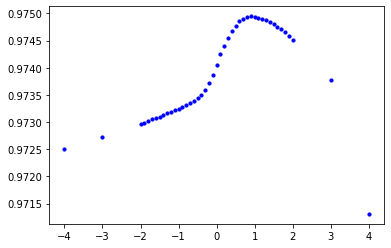

In [38]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(auc_weakties.index, auc_weakties.AUC, s=10, c='b', marker="o")

plt.show()

In [39]:
print('The optimal alpha is {}'.format(auc_weakties.AUC.idxmax()))

The optimal alpha is 0.9


In [60]:
max(auc_weakties.AUC)

0.9722718514762362

# SVM AUC calculatoin

## Unweighted Features

In [47]:
from sklearn import svm
y = train['Exist']
X = train.drop(columns=["Pair", "Source", "Sink", "Exist"])
X_test = test.drop(columns=["Pair", "Source", "Sink", "Exist"])

clf = svm.SVC(probability=True, max_iter=20000)
y_pred = clf.fit(X_test, y_test).predict_proba(X_test)
roc_auc_score(y_test, y_pred[:,1])

0.8553741055545803

## Weak ties

In [53]:
alphas = [-4.0, -3.0] + [round(a*0.1,1) for a in range(-20, 21)] + [3.0, 4.0]
auc_weakties = []
for a in alphas:
    test_w = pd.read_csv("test_alphas/test_w_{}.csv".format(a))
    train_w = pd.read_csv("alphas/train_w_{}.csv".format(a))
    
    weakties = ["WCN", "WAA", "WRA"] # weak ties feature list
    X = train_w[weakties]
    X_test = test_w[weakties]
    #X_test.insert(0,'Intercept',1)
    y = train['Exist']
    y_test = test['Exist']
    
    clf = svm.SVC(probability=True, max_iter=20000)
    y_pred = clf.fit(X_test, y_test).predict_proba(X_test)
    
    auc_weakties.append(roc_auc_score(y_test, y_pred[:,1]))
    
    
auc_weakties = pd.DataFrame(auc_weakties, columns=["AUC"])
auc_weakties.index = alphas
auc_weakties

,AUC
-4.0,0.968982
-3.0,0.968341
-2.0,0.968364
-1.9,0.968376
-1.8,0.968407
-1.7,0.968450
-1.6,0.968499
-1.5,0.968554
-1.4,0.968619
-1.3,0.968669


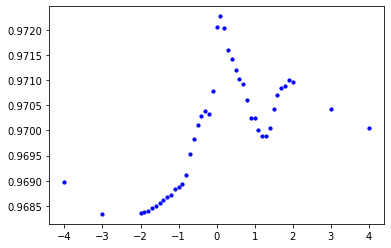

In [54]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(auc_weakties.index, auc_weakties.AUC, s=10, c='b', marker="o")

plt.show()

In [55]:
print('The optimal alpha is {}'.format(auc_weakties.AUC.idxmax()))

The optimal alpha is 0.1
